In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,LayerNormalization, Flatten, LeakyReLU, ReLU
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D, MaxPooling3D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.merge import concatenate, add, average, subtract
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras.activations import sigmoid

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=8000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#Image Directory
drr_train_images = r'D:\Models\Resolution Calc\train\images.tif'
drr_train_labels = r'D:\Models\Resolution Calc\train\FWHM.csv'

images = imread(drr_train_images).astype(np.float32)
labels = open(drr_train_labels)
labels = np. loadtxt(labels, delimiter=",")

In [5]:
fft_images=np.zeros(images.shape,dtype=np.complex64)
fft_images = np.zeros((fft_images.shape[0],fft_images.shape[1],fft_images.shape[2],1),dtype=np.complex64)
print(fft_images.shape)
for i in range(len(images)):
    fft_images[i,:,:,0]=np.fft.fftn(images[i])
    fft_images[i,:,:,0]=np.fft.fftshift(fft_images[i,:,:,0])
# fft_images_r[:,:,:,0] = fft_images.real
# fft_images_r[:,:,:,1] = fft_images.imag
# fft_images_a = abs(fft_images)
# for i in range(len(images)):
#     fft_images_r[i,:,:,0] = fft_images_r[i,:,:,0]/fft_images_r[i,:,:,0].max()
#     fft_images_r[i,:,:,1] = fft_images_r[i,:,:,1]/fft_images_r[i,:,:,1].max()
fft_images = abs(fft_images)
for i in range(len(images)):
    fft_images[i] = fft_images[i]/fft_images[i].max()

(799, 1024, 1024, 1)


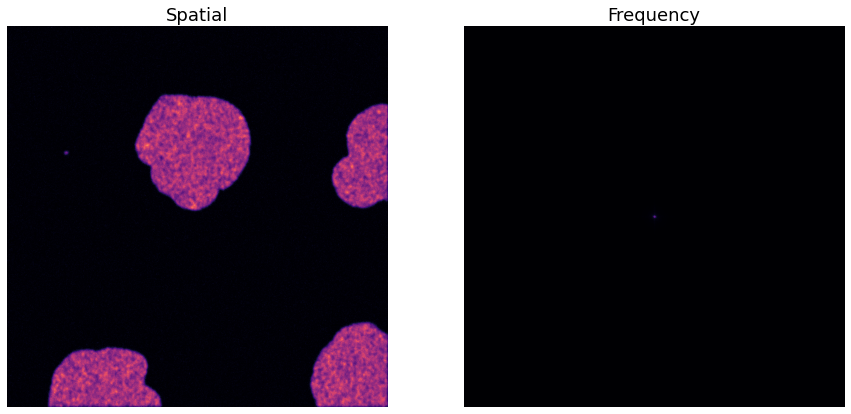

In [6]:
ix = random.randint(0, len(images))
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,2, 1)
cmap=plt.get_cmap('magma')
plt.imshow(images[ix].squeeze(),cmap)
plt.title('Spatial',fontdict={'fontsize':18})
plt_axis = plt.axis('off')


fig.add_subplot(1,2, 2)
cmap=plt.get_cmap('magma')
plt.imshow(fft_images[ix,:,:,0].squeeze(),cmap)
plt.title('Frequency',fontdict={'fontsize':18})
plt_axis = plt.axis('off')

In [7]:
def dis_conv_block(inpt,num_filters=8,kernel_shape=(3,3)):
    x = Conv2D(num_filters, kernel_shape, padding="same",strides=(1,1))(inpt)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(num_filters, kernel_shape, padding="same",strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

def make_cnn(inpt,num_filters=8,kernel_shape=(3,3),dropout=0.3):
    x = dis_conv_block(inpt,num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,2*num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,4*num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,8*num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,16*num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = dis_conv_block(x,16*num_filters,kernel_shape)
    x = Dropout(dropout)(x)
    x = Conv2D(2, kernel_shape, padding="same",strides=(1,1))(x)
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=inpt, outputs=[x])
    return model


In [8]:
inpt = Input((1024,1024,1))
model_cnn=make_cnn(inpt, num_filters=32,kernel_shape=(3,3),dropout=0.2)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_cnn.compile(optimizer=opt,loss='mse',metrics=['mse'])
# model_cnn.summary()
#plot_model(model_cnn,show_shapes=True, show_layer_names=True, dpi=80)

In [9]:
model_save_directory = r'D:\Models\Resolution Calc\model-cnn-resolutioncalc-20220718.h5'
callbacks = [
    EarlyStopping(patience=50, verbose=1),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=8,verbose=1,min_lr=1e-7)
]

In [10]:
results = model_cnn.fit(x=fft_images, y = labels, batch_size=4,epochs=200,callbacks=callbacks,validation_split=0.2)

Epoch 1/200
160/160 [==============================] - ETA: 0s - loss: 0.0847 - mse: 0.0847
Epoch 00001: val_loss improved from inf to 0.32080, saving model to D:\Models\Resolution Calc\model-cnn-resolutioncalc-20220718.h5
160/160 [==============================] - 23s 107ms/step - loss: 0.0847 - mse: 0.0847 - val_loss: 0.3208 - val_mse: 0.3208 - lr: 1.0000e-04
Epoch 2/200
160/160 [==============================] - ETA: 0s - loss: 0.0647 - mse: 0.0647
Epoch 00002: val_loss improved from 0.32080 to 0.13106, saving model to D:\Models\Resolution Calc\model-cnn-resolutioncalc-20220718.h5
160/160 [==============================] - 16s 99ms/step - loss: 0.0647 - mse: 0.0647 - val_loss: 0.1311 - val_mse: 0.1311 - lr: 1.0000e-04
Epoch 3/200
160/160 [==============================] - ETA: 0s - loss: 0.0442 - mse: 0.0442
Epoch 00003: val_loss improved from 0.13106 to 0.08247, saving model to D:\Models\Resolution Calc\model-cnn-resolutioncalc-20220718.h5
160/160 [==============================] -

160/160 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0075
Epoch 00027: val_loss did not improve from 0.00382
160/160 [==============================] - 16s 100ms/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0079 - val_mse: 0.0079 - lr: 2.0000e-05
Epoch 28/200
160/160 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055
Epoch 00028: val_loss did not improve from 0.00382
160/160 [==============================] - 16s 98ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0432 - val_mse: 0.0432 - lr: 2.0000e-05
Epoch 29/200
160/160 [==============================] - ETA: 0s - loss: 0.0056 - mse: 0.0056
Epoch 00029: val_loss did not improve from 0.00382
160/160 [==============================] - 16s 98ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0040 - val_mse: 0.0040 - lr: 2.0000e-05
Epoch 30/200
160/160 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044
Epoch 00030: val_loss did not improve from 0.00382

Epoch 00030: Re

Epoch 54/200
160/160 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031
Epoch 00054: val_loss did not improve from 0.00231
160/160 [==============================] - 16s 100ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0026 - val_mse: 0.0026 - lr: 1.6000e-07
Epoch 55/200
160/160 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036
Epoch 00055: val_loss did not improve from 0.00231
160/160 [==============================] - 16s 101ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0024 - val_mse: 0.0024 - lr: 1.6000e-07
Epoch 56/200
160/160 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040
Epoch 00056: val_loss did not improve from 0.00231
160/160 [==============================] - 16s 99ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0024 - val_mse: 0.0024 - lr: 1.6000e-07
Epoch 57/200
160/160 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033
Epoch 00057: val_loss did not improve from 0.00231
16

KeyboardInterrupt: 

In [95]:
#Image Directory
drr_test_images = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\STED\20210827-USF\STED 70\sted\Average\Average.tif'
# drr_test_labels = "/content/drive/My Drive/data/Synthetic_data_resolution_calc/test/FWHM.csv"

test_images = imread(drr_test_images).astype(np.float32)
test_images = test_images[:,0:1024,0:1024]
# test_labels = open(drr_test_labels)
# test_labels = np. loadtxt(test_labels, delimiter=",")

test_fft_images=np.zeros(test_images.shape,dtype=np.complex64)
test_fft_images = np.zeros((test_fft_images.shape[0],test_fft_images.shape[1],test_fft_images.shape[2],1),dtype=np.complex64)

for i in range(len(test_images)):
    test_fft_images[i,:,:,0]=np.fft.fftn(test_images[i])
    test_fft_images[i,:,:,0]=np.fft.fftshift(test_fft_images[i,:,:,0])

test_fft_images = abs(test_fft_images)
for i in range(len(test_images)):
    test_fft_images[i] = test_fft_images[i]/test_fft_images[i].max()

In [96]:
inpt1 = Input((1024,1024,1))
# inpt1 = Input((2048,2048,1))

model_cnn1=make_cnn(inpt1, num_filters=32,kernel_shape=(3,3),dropout=0.2)
model_cnn1.load_weights(r'D:\Models\Resolution Calc\model-cnn-resolutioncalc-20220718.h5')

In [97]:
pred = np.zeros((len(test_fft_images),2))
for i in range(len(test_fft_images)):
    pred[i:i+1] = model_cnn1.predict(test_fft_images[i:i+1])

In [98]:
print(pred.mean())

1.1057491103808086


In [ ]:
pred = np.zeros((X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1))
for i in range(X_valid.shape[0]):
  pred[i] = gen_model.predict(X_valid[i:i+1,:,:,10,:])

In [ ]:
ix = np.random.randint(len(pred))
#ix = 0
fig = plt.figure(figsize = (20,15))
for i in range(1):
  plt.subplot(1, 3, 1)
  plt.imshow(X_valid[ix, :, :, 0] , cmap='magma')
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.imshow(pred[ix, :, :, 0] , cmap='magma')
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.imshow(Y_valid[ix, :, :, 0] , cmap='magma')
  plt.axis('off')